In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

%matplotlib inline

# Input data files are available in the "/tf/data" directory.
print(os.listdir("/tf/data"))

['heart.csv']


# The Data

Next, load the data,

In [22]:
df = pd.read_csv("/tf/data/heart.csv")

In [23]:
df.head(7)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1


**It's a clean, easy to understand set of data. However, the meaning of some of the column headers are not obvious. Here's what they mean,**

- **age**: The person's age in years
- **sex**: The person's sex (1 = male, 0 = female)
- **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
- **chol:** The person's cholesterol measurement in mg/dl
- **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false) 
- **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach:** The person's maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more [here](https://litfl.com/st-segment-ecg-library/))
- **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca:** The number of major vessels (0-3)
- **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target:** Heart disease (0 = no, 1 = yes)

To avoid [HARKing](https://journals.sagepub.com/doi/abs/10.1207/s15327957pspr0203_4) (or Hypothesizing After the Results are Known) We're going to take a look at online guides on how heart disease is diagnosed, and look up some of the terms above.

**Diagnosis**: The diagnosis of heart disease is done on a combination of clinical signs and test results. The types of tests run will be chosen on the basis of what the physician thinks is going on [1](https://www.mayoclinic.org/diseases-conditions/heart-disease/diagnosis-treatment/drc-20353124), ranging from electrocardiograms and cardiac computerized tomography (CT) scans, to blood tests and exercise stress tests [2](https://www.heartfoundation.org.au/your-heart/living-with-heart-disease/medical-tests).

Looking at information of heart disease risk factors led me to the following: **high cholesterol, high blood pressure, diabetes, weight, family history and smoking** [3](https://www.bhf.org.uk/informationsupport/risk-factors). According to another source [4](https://www.heart.org/en/health-topics/heart-attack/understand-your-risks-to-prevent-a-heart-attack), the major factors that can't be changed are: **increasing age, male gender and heredity**. Note that **thalassemia**, one of the variables in this dataset, is heredity. Major factors that can be modified are: **Smoking, high cholesterol, high blood pressure, physical inactivity, and being overweight and having diabetes**. Other factors include **stress, alcohol and poor diet/nutrition**.

We can see no reference to the 'number of major vessels', but given that the definition of heart disease is **"...what happens when your heart's blood supply is blocked or interrupted by a build-up of fatty substances in the coronary arteries"**, it seems logical the *more* major vessels is a good thing, and therefore will reduce the probability of heart disease.

Given the above, We would hypothesis that, if the model has some predictive ability, we'll see these factors standing out as the most important.

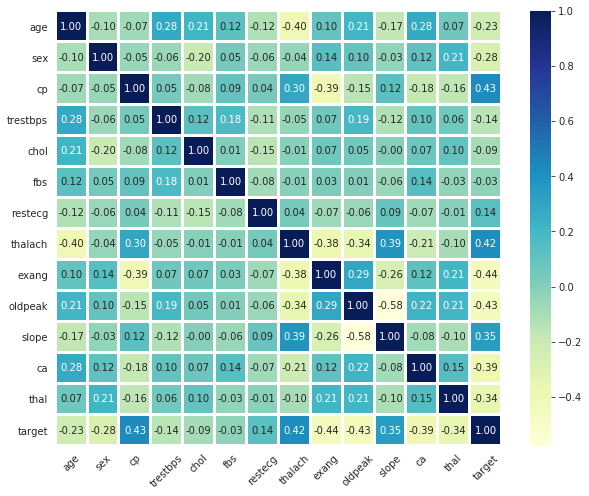

In [24]:
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(df.corr(), annot=True, cmap='YlGnBu', fmt='.2f', linewidths=2)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45);

In [25]:
# change column names
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

# change the values of the categorical variables, to improve the interpretation later on,
df.sex[df.sex == 0] = 'female'
df.sex[df.sex == 1] = 'male'

df.chest_pain_type[df.chest_pain_type == 1] = 'typical angina'
df.chest_pain_type[df.chest_pain_type == 2] = 'atypical angina'
df.chest_pain_type[df.chest_pain_type == 3] = 'non-anginal pain'
df.chest_pain_type[df.chest_pain_type == 4] = 'asymptomatic'

df.fasting_blood_sugar[df.fasting_blood_sugar == 0] = 'lower than 120mg/ml'
df.fasting_blood_sugar[df.fasting_blood_sugar == 1] = 'greater than 120mg/ml'

df.rest_ecg[df.rest_ecg == 0] = 'normal'
df.rest_ecg[df.rest_ecg == 1] = 'ST-T wave abnormality'
df.rest_ecg[df.rest_ecg == 2] = 'left ventricular hypertrophy'

df.exercise_induced_angina[df.exercise_induced_angina == 0] = 'no'
df.exercise_induced_angina[df.exercise_induced_angina == 1] = 'yes'

df.st_slope[df.st_slope == 1] = 'upsloping'
df.st_slope[df.st_slope == 2] = 'flat'
df.st_slope[df.st_slope == 3] = 'downsloping'

df.thalassemia[df.thalassemia == 1] = 'normal'
df.thalassemia[df.thalassemia == 2] = 'fixed defect'
df.thalassemia[df.thalassemia == 3] = 'reversable defect'

df.target[df.target == 0] = 'no disease'
df.target[df.target == 1] = 'disease'

In [26]:
df.head(7)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,non-anginal pain,145,233,greater than 120mg/ml,normal,150,no,2.3,0,0,normal,disease
1,37,male,atypical angina,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,0,0,fixed defect,disease
2,41,female,typical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,flat,0,fixed defect,disease
3,56,male,typical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,flat,0,fixed defect,disease
4,57,female,0,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,flat,0,fixed defect,disease
5,57,male,0,140,192,lower than 120mg/ml,ST-T wave abnormality,148,no,0.4,upsloping,0,normal,disease
6,56,female,typical angina,140,294,lower than 120mg/ml,normal,153,no,1.3,upsloping,0,fixed defect,disease


In [27]:
df.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                      object
dtype: object

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age                        303 non-null int64
sex                        303 non-null object
chest_pain_type            303 non-null object
resting_blood_pressure     303 non-null int64
cholesterol                303 non-null int64
fasting_blood_sugar        303 non-null object
rest_ecg                   303 non-null object
max_heart_rate_achieved    303 non-null int64
exercise_induced_angina    303 non-null object
st_depression              303 non-null float64
st_slope                   303 non-null object
num_major_vessels          303 non-null int64
thalassemia                303 non-null object
target                     303 non-null object
dtypes: float64(1), int64(5), object(8)
memory usage: 33.2+ KB


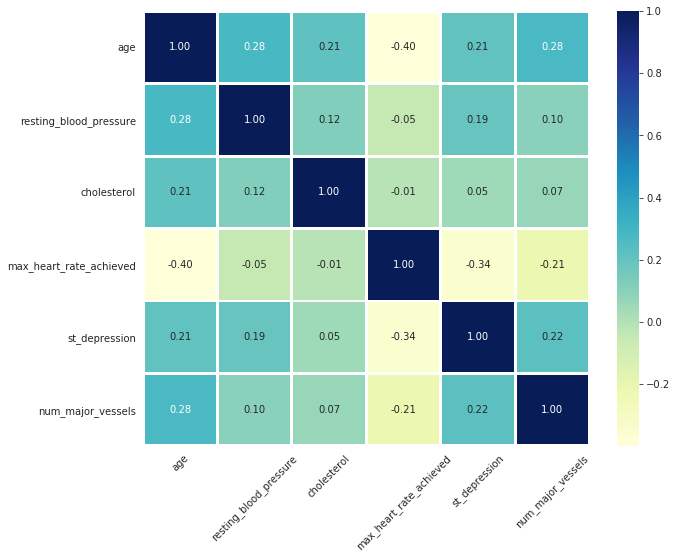

In [29]:
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(df.corr(), annot=True, cmap='YlGnBu', fmt='.2f', linewidths=2)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45);

In [30]:
df.target.value_counts()

disease       165
no disease    138
Name: target, dtype: int64

In [31]:
countNoDisease = len(df[df.target == 'no disease'])
countHaveDisease = len(df[df.target == 'disease'])
print("Percentage of Patients Haven't Heart Disease: {:.2f}%".format((countNoDisease / (len(df.target))*100)))
print("Percentage of Patients Have Heart Disease: {:.2f}%".format((countHaveDisease / (len(df.target))*100)))


Percentage of Patients Haven't Heart Disease: 45.54%
Percentage of Patients Have Heart Disease: 54.46%


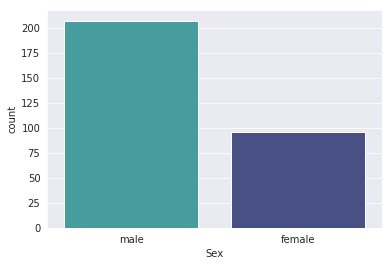

In [32]:
sns.countplot(x='sex', data=df, palette="mako_r")
plt.xlabel("Sex")
plt.show()

In [33]:
df.groupby('target').mean()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels
target,,,,,,
disease,52.496970,129.303030,242.230303,158.466667,0.583030,0.363636
no disease,56.601449,134.398551,251.086957,139.101449,1.585507,1.166667


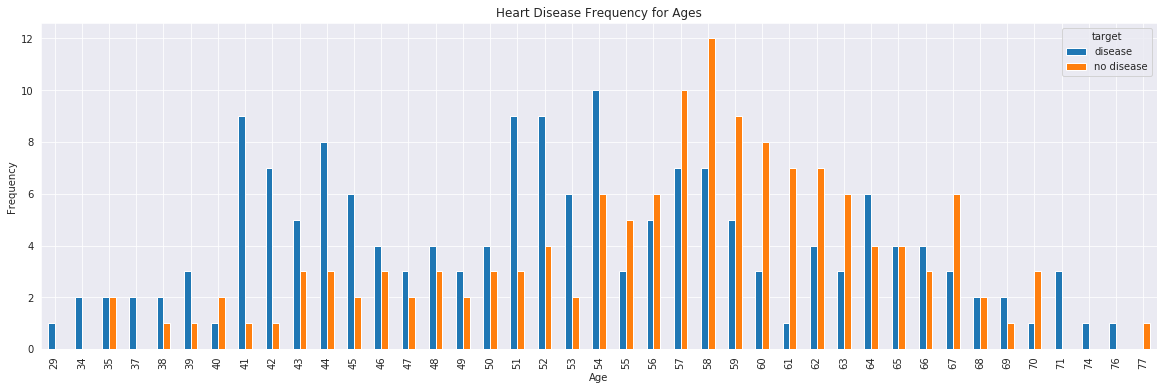

In [34]:
pd.crosstab(df.age,df.target).plot(kind="bar", figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('heartDiseaseAndAges.png')
plt.show()

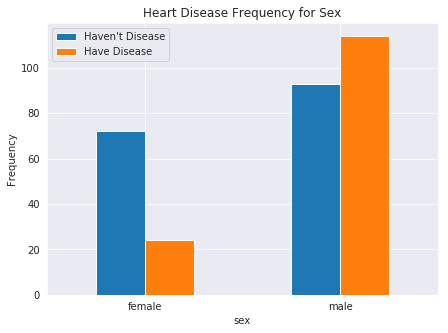

In [35]:
pd.crosstab(df.sex,df.target).plot(kind="bar", figsize=(7,5))
plt.title('Heart Disease Frequency for Sex')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Sex vs Age - Point Plot')

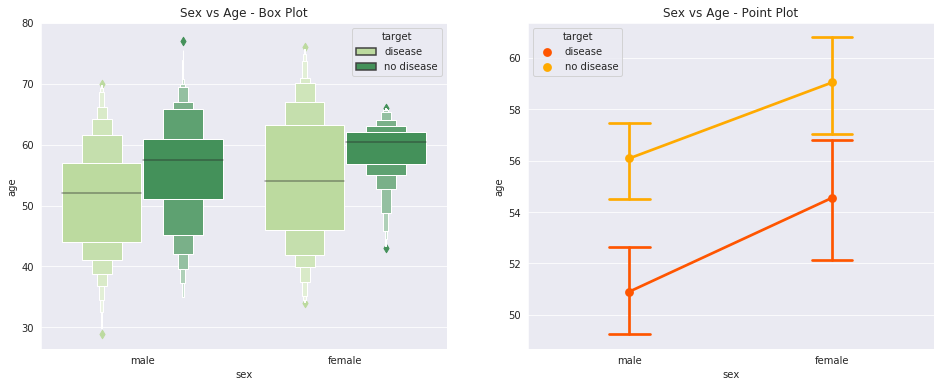

In [36]:
fig, ax = plt.subplots(figsize=(16,6))
plt.subplot(121)
s1 = sns.boxenplot(x='sex', y='age', hue='target', data=df, palette='YlGn', linewidth=3)
s1.set_title("Sex vs Age - Box Plot")
#Figure 1 says most of females having heart disease range from 40-70yrs and men from 40-60yrs

plt.subplot(122)
s2 = sns.pointplot(x='sex', y='age', hue='target', data=df, palette='autumn', capsize=0.2)
s2.set_title("Sex vs Age - Point Plot")
#Figure 2 says mean age for female with heart disease around 54yrs and for males around 51yrs

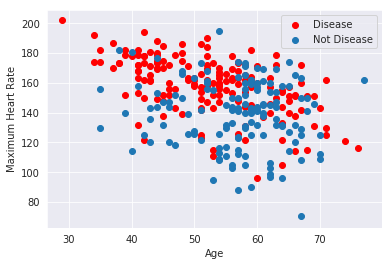

In [37]:
plt.scatter(x=df.age[df.target == 'disease'], y=df.max_heart_rate_achieved[(df.target == 'disease')], c="red")
plt.scatter(x=df.age[df.target == 'no disease'], y=df.max_heart_rate_achieved[(df.target == 'no disease')])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

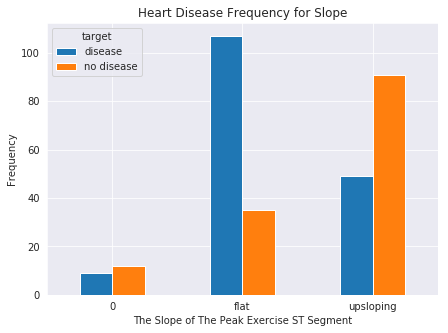

In [38]:
pd.crosstab(df.st_slope, df.target).plot(kind="bar", figsize=(7,5))
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

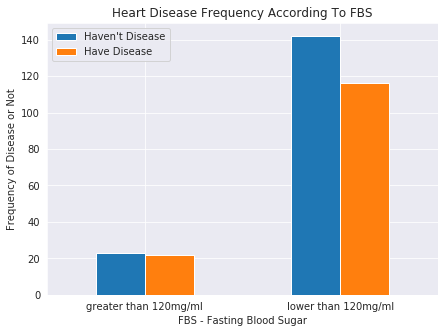

In [39]:
pd.crosstab(df.fasting_blood_sugar, df.target).plot(kind="bar", figsize=(7,5))
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - Fasting Blood Sugar')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

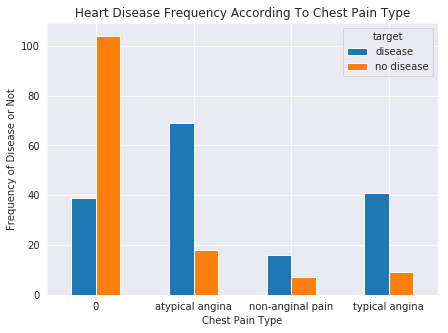

In [40]:
pd.crosstab(df.chest_pain_type, df.target).plot(kind="bar", figsize=(7,5))
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()